In [1]:
(0.002*5e15)/1e14 * 100

10.0

In [2]:
26301369863.0137/-31132354000000.0 * 100

-0.08448243220867171

# BOB - the Big-Ole-Budget
## Objective: We hope to 
#### a) find the relative magnitudes of sources and sinks of carbon in the system
#### b) check if the found sources and sinks account for the changing carbon balance of the system as reported by the model


## BUDGET run specs:

    
    run dir: SS-run-sets/SalishSea/nemo3.6/tereza/FUTURE_runs/BUDGET_2017_RUN
    branch of run dir: TJSJ_future_runs
    config dir: NEMO-3.6-code/NEMOGCM/CONFIG/SalishSeaCast
    branch of config dir: TJSJ_future_forprod
    results on graham: /scratch/tjarnik/BUDGET
    results on salish: /data/tjarniko/results/FUTURE_runs/BUDGET/01jan17_RIVTA5/
    run suffix: RIVTA5
    
Equivalence notebook: 

http://localhost:8802/notebooks/notebooks/RIVER_PAPER/BUDGET/equivalence_check-RIVTA_and_PRDREM_METRICS.ipynb
    
   


In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
import numpy as np
# import xarray as xr
import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
# from scipy.io import loadmat
from cmocean import cm
import pandas as pd

import pickle
import arrow
#from cartopy import crs, feature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from salishsea_tools import viz_tools
import netCDF4 as nc
import glob
from decimal import Decimal

#import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 11

import warnings
warnings.simplefilter('ignore')


## Start budgeting

Governing source-sink equations of the system (as written in MM16/Jarnikova20whatever):

$\frac{\partial DIC}{\partial t } = - (U_{N} + U_{PC} - Rm_{N}) * R_{C:N} + {physical transport} + {airsea flux} $ 

$\frac{\partial TA}{\partial t } = U_{NO3-} - 2Rm_{NO3-} - U_{NH4+} + Rm_{NH4+} + (U_{PO4} + Rm_{PO4})* R_{N:P} + {physical transport}$ 


Decision i've made: 

    - everything calculated 20 grid cells (10 km) in from boundary


- things we need: 

- carbon content of domain daily (mmol)
            - one way to get that is (daily average DIC) * (e1t*e2t*e3t)
            - one way to get that is through DIC_e3tsnap * (e1t*e2t)
                -instantaneous-at-END-of-day DIC concentration * e3t at that time (changes due to tidal range)
- change in daily carbon content (subtract daily values of the above)

this change should be equal to the sum of the daily totals of:

- river carbon input (RIV_DIC (mmol/s))
- carbon taken up by phytoplankton (mmol/s)
- carbon remineralized (mmol/s)
- carbon going through the western boundary (mmol/s)
- carbon going through the northern boundary (mmol/s)
- carbon going through the air-sea boundary (air_sea_carbon * e1t*e2t, mmol/s)

            

In [5]:
print('hm')

hm


In [6]:
# dimensional conversion variables 

#meshmask
mmk = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
e2t = (mmk['e2t'][0,:,:])
e1t = (mmk['e1t'][0,:,:])
surfar_m2 = e1t * e2t
tmask_orig = mmk['tmask'][0,:,:,:]
tmask = (mmk['tmask'][0,:,:,:])

# cut edges
tmask[:,878:898,0:100] = 0
tmask[:,:,0:20] = 0

surfar_m2[878:898,0:100] = 0
surfar_m2[:,0:20] = 0

surfar_m2_broad = np.zeros([40,898,398])

for i in range(0,40):
    surfar_m2_broad[i,:,:] = surfar_m2

surfar_m2_mask = surfar_m2_broad * tmask

#seconds in day
sid = 60*60*24

### notes and variables for conversion

    sid --- seconds in day, 86400
    surfar_m2_broad --- surface area of cell in m2 * tmask (20 grid cells from left and top edge cut), 40x898x398
    tmask --- 40x898x398 (20 grid cells from left and top edge cut)
    1 m3 = 1e-9 km3

In [7]:
## open relevant files - test with one day

daystr = '20170101'
q4 = '/data/tjarniko/results/FUTURE_runs/BUDGET/*_RIVTA5/'

prdrem = glob.glob(f'{q4}*_1d_*_PRDREM_T_{daystr}-{daystr}.nc')
prdrem_boi = nc.Dataset(prdrem[0])
carp = glob.glob(f'{q4}*_1d_*_carp_T_{daystr}-{daystr}.nc')
carp_boi = nc.Dataset(carp[0])
dianu = glob.glob(f'{q4}*_1d_*_dian_U_{daystr}-{daystr}.nc')
dianu_boi = nc.Dataset(dianu[0])
dianv = glob.glob(f'{q4}*_1d_*_dian_V_{daystr}-{daystr}.nc')
dianv_boi = nc.Dataset(dianv[0])

#### function to get BOB numbers out, option to print with sci. not. 

In [8]:
daystr = '20170111'
### function to get bob numbers

def find_bob_numbers(daystr, verbose = True, advdif = False):
    
    if advdif:
        q4 = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*_RIVTA5/'
    else:
        q4 = '/data/tjarniko/results/FUTURE_runs/BUDGET/*_RIVTA5/'
        
    prdrem = glob.glob(f'{q4}*_1d_*_PRDREM_T_{daystr}-{daystr}.nc')
    prdrem_boi = nc.Dataset(prdrem[0])
    carp = glob.glob(f'{q4}*_1d_*_carp_T_{daystr}-{daystr}.nc')
    carp_boi = nc.Dataset(carp[0])
    dianu = glob.glob(f'{q4}*_1d_*_dian_U_{daystr}-{daystr}.nc')
    dianu_boi = nc.Dataset(dianu[0])
    dianv = glob.glob(f'{q4}*_1d_*_dian_V_{daystr}-{daystr}.nc')
    dianv_boi = nc.Dataset(dianv[0])

    e3t = carp_boi['e3t'][0,:,:,:]
    vol_m3 = surfar_m2_mask * e3t 
    vol_km3_tot = np.nansum(vol_m3) * 1e-9
    
    ## TOTAL DIC IN SYSTEM IN MMOLS
    e3t = carp_boi['e3t'][0,:,:,:]
    DIC = carp_boi['dissolved_inorganic_carbon'][0,:,:,:]
    DIC_mmol = DIC * e3t* surfar_m2_mask 
    DIC_mmol_tot = np.nansum(DIC_mmol)

    DIC_SNAP = carp_boi['DIC_E3TSNAP'][0,:,:,:]
    DIC_SNAP_mmol = DIC_SNAP * surfar_m2_mask 
    DIC_SNAP_mmol_tot = np.nansum(DIC_SNAP_mmol)

    #### total DIC input in rivers
    # ?? when multiply river_DIC by tmask, stuff gets cut out? tthere must be a river coming in near the boundary 

    riverine_DIC = prdrem_boi['riverine DIC'][0,:,:,:]  * tmask
    riv_DIC_mmol_day_tot = np.nansum(riverine_DIC) * sid
    
    ### total DIC taken up by production 
    PRD_DIC = prdrem_boi['PRD DIC'][0,:,:,:]  * tmask
    PRD_DIC_mmol_day_tot = np.nansum(PRD_DIC) * sid 

    UNC_DIC = prdrem_boi['Uncoupled DIC uptake'][0,:,:,:]  * tmask
    UNC_DIC_mmol_day_tot = np.nansum(UNC_DIC) * sid * (-1)
    ### total DIC remineralized
    REM_DIC = prdrem_boi['REM DIC'][0,:,:,:]  * tmask
    REM_DIC_mmol_day_tot = np.nansum(REM_DIC) * sid 

    DIC_UT = dianu_boi['DIC_UT'][0,:,:,19] * sid 
    DIC_UT_mmol_day_pos = np.nansum(DIC_UT[DIC_UT>=0])
    DIC_UT_mmol_day_neg = np.nansum(DIC_UT[DIC_UT<=0])
    DIC_UT_mmol_day_tot = np.nansum(DIC_UT) 

    ## this is johnstone strait. negative is INTO DOMAIN
    DIC_VT = dianv_boi['DIC_VT'][0,:,877,0:100] * (-1)  * sid 
    DIC_VT_mmol_day_pos = np.nansum(DIC_VT[DIC_VT>=0])
    DIC_VT_mmol_day_neg = np.nansum(DIC_VT[DIC_VT<=0])
    DIC_VT_mmol_day_tot = np.nansum(DIC_VT)
    
    if advdif: 
    #atx aty
        advdif = glob.glob(f'{q4}*_1d_*_advdif_T_{daystr}-{daystr}.nc')
        advdif_boi = nc.Dataset(advdif[0])

        ATF_DIC = advdif_boi['ATF DIC'][0,:,:,:]  * tmask *sid 
        ATF_DIC_mmol_day_tot = np.nansum(ATF_DIC) 
        
        ATX_DIC = advdif_boi['ATX DIC'][0,:,:,19] * sid 
        ATX_DIC_mmol_day_pos = np.nansum(ATX_DIC[ATX_DIC>=0])
        ATX_DIC_mmol_day_neg = np.nansum(ATX_DIC[ATX_DIC<=0])
        ATX_DIC_mmol_day_tot = np.nansum(ATX_DIC) 
      
        ATY_DIC = advdif_boi['ATY DIC'][0,:,877,0:100] *  (-1) * sid 
        ATY_DIC_mmol_day_pos = np.nansum(ATY_DIC[ATY_DIC>=0])
        ATY_DIC_mmol_day_neg = np.nansum(ATY_DIC[ATY_DIC<=0])
        ATY_DIC_mmol_day_tot = np.nansum(ATY_DIC) 

        DTX_DIC = advdif_boi['DTX DIC'][0,:,:,19] * sid 
        DTX_DIC_mmol_day_pos = np.nansum(DTX_DIC[DTX_DIC>=0])
        DTX_DIC_mmol_day_neg = np.nansum(DTX_DIC[DTX_DIC<=0])
        DTX_DIC_mmol_day_tot = np.nansum(DTX_DIC) 

        DTY_DIC = advdif_boi['DTY DIC'][0,:,877,0:100] * (-1) * sid 
        DTY_DIC_mmol_day_pos = np.nansum(DTY_DIC[DTY_DIC>=0])
        DTY_DIC_mmol_day_neg = np.nansum(DTY_DIC[DTY_DIC<=0])
        DTY_DIC_mmol_day_tot = np.nansum(DTY_DIC) 

        

    ASflux = carp_boi['co2_flux_mmol_m2_s'][0,:,:]
    ASflux_mmol_day_tot = np.nansum(ASflux* surfar_m2_mask[0,:,:]) *sid

    #daychange = 

    if advdif:
        daychange_new = ASflux_mmol_day_tot + \
        ATX_DIC_mmol_day_tot + ATY_DIC_mmol_day_tot + \
        DTX_DIC_mmol_day_tot + DTY_DIC_mmol_day_tot +\
        REM_DIC_mmol_day_tot + PRD_DIC_mmol_day_tot + \
        riv_DIC_mmol_day_tot + ATF_DIC_mmol_day_tot
        
        daychange = ASflux_mmol_day_tot + \
        DIC_VT_mmol_day_tot + DIC_UT_mmol_day_tot + \
        REM_DIC_mmol_day_tot + PRD_DIC_mmol_day_tot + \
        riv_DIC_mmol_day_tot 
    
    else: 
        daychange = ASflux_mmol_day_tot + \
        DIC_VT_mmol_day_tot + DIC_UT_mmol_day_tot + \
        REM_DIC_mmol_day_tot + PRD_DIC_mmol_day_tot + \
        riv_DIC_mmol_day_tot 
    
    
    if verbose:
        print(f'day is {daystr}')
        print('km3 water in system (day average):')
        print(f"{Decimal(vol_km3_tot):.8E}")

        print('')
        print('mmols DIC in system (day average):')
        print(f"{Decimal(DIC_mmol_tot):.8E}")
        print('mmols DIC in system (snapshot at midnight):')
        print(f"{Decimal(DIC_SNAP_mmol_tot):.8E}")

        print('')
        print('DIC coming in through rivers (mmol/day):')
        print(f"{Decimal(riv_DIC_mmol_day_tot):.8E}")

        print('DIC taken up by phyto (mmol/day):')
        print(f"{Decimal(PRD_DIC_mmol_day_tot):.8E}")

        print('UNCOUPLED DIC taken up by phyto (mmol/day):')
        print(f"{Decimal(UNC_DIC_mmol_day_tot):.8E}")

        print('DIC remineralized! (mmol/day):')
        print(f"{Decimal(REM_DIC_mmol_day_tot):.8E}")

        print('DIC through western JDF boundary (+ = in, to the east, mmol/day)')
        print(f"{Decimal(DIC_UT_mmol_day_tot):.8E}")

        print('DIC through northern JS boundary (+ = in, to the south, mmol/day)')
        print(f"{Decimal(DIC_VT_mmol_day_tot):.8E}")

        print('Air-sea flux (+ = in, from air to sea, mmol/day)')
        print(f"{Decimal(ASflux_mmol_day_tot):.8E}")

        print('')
        print('total change in DIC from all sources and sinks today (mmol/day):')
        print(f"{Decimal(daychange):.8E}")
    
    if advdif:
        return vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, \
DIC_UT_mmol_day_tot, DIC_VT_mmol_day_tot, ASflux_mmol_day_tot, daychange, daychange_new,\
DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg, \
ATX_DIC_mmol_day_tot, ATX_DIC_mmol_day_pos, ATX_DIC_mmol_day_neg, \
ATY_DIC_mmol_day_tot, ATY_DIC_mmol_day_pos, ATY_DIC_mmol_day_neg, \
DTX_DIC_mmol_day_tot, DTX_DIC_mmol_day_pos, DTX_DIC_mmol_day_neg, \
DTY_DIC_mmol_day_tot, DTY_DIC_mmol_day_pos, DTY_DIC_mmol_day_neg, \
ATF_DIC_mmol_day_tot
    
    else:
        return vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, \
DIC_UT_mmol_day_tot, DIC_VT_mmol_day_tot, ASflux_mmol_day_tot, daychange, \
DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg

print('advdif')
vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, DIC_UT_mmol_day_tot, \
DIC_VT_mmol_day_tot, ASflux_mmol_day_tot, daychange, daychange_new,\
DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg, \
ATX_DIC_mmol_day_tot, ATX_DIC_mmol_day_pos, ATX_DIC_mmol_day_neg, \
ATY_DIC_mmol_day_tot, ATY_DIC_mmol_day_pos, ATY_DIC_mmol_day_neg, \
DTX_DIC_mmol_day_tot, DTX_DIC_mmol_day_pos, DTX_DIC_mmol_day_neg, \
DTY_DIC_mmol_day_tot, DTY_DIC_mmol_day_pos, DTY_DIC_mmol_day_neg, \
ATF_DIC_mmol_day_tot \
= find_bob_numbers(daystr, verbose = False, advdif = True)
print('standard daychange')
print(daychange)
print('new daychange')
print(daychange_new)
print('UTVT')
vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, \
DIC_UT_mmol_day_tot, DIC_VT_mmol_day_tot, ASflux_mmol_day_tot, daychange, \
DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg \
= find_bob_numbers(daystr, verbose = False, advdif = False)
print(daychange)
print('DIC_UT_mmol_day_tot')
print(DIC_UT_mmol_day_tot)
print('ATX_DIC_mmol_day_tot')
print(ATX_DIC_mmol_day_tot)
print('DTX_DIC_mmol_day_tot')
print(DTX_DIC_mmol_day_tot)
print()
print('DIC_VT_mmol_day_tot')
print(DIC_VT_mmol_day_tot)
print('ATY_DIC_mmol_day_tot')
print(ATY_DIC_mmol_day_tot)
print('DTY_DIC_mmol_day_tot')
print(DTY_DIC_mmol_day_tot)
print('ATF_DIC_mmol_day_tot')
print(ATF_DIC_mmol_day_tot)

# river carbon input (RIV_DIC (mmol/s))
# carbon taken up by phytoplankton (mmol/s)
# carbon remineralized (mmol/s)
# carbon going through the western boundary (mmol/s)
# carbon going through the northern boundary (mmol/s)
# carbon going through the air-sea boundary (air_sea_carbon * e1t*e2t, mmol/s)

advdif
standard daychange
6546115826286.485
new daychange
6547779147218.474
UTVT
6476785571674.886
DIC_UT_mmol_day_tot
5164468652260.877
ATX_DIC_mmol_day_tot
5242175642197.814
DTX_DIC_mmol_day_tot
-391953539.7675365

DIC_VT_mmol_day_tot
1451429668289.795
ATY_DIC_mmol_day_tot
1444660982583.1375
DTY_DIC_mmol_day_tot
114777799.17610176
ATF_DIC_mmol_day_tot
490133062.4842154


## workhorse bob-getting-cell

In [9]:
dayslen = 365

In [10]:
start ='2017-01-01'
end ='2017-12-31'

runhorse = False

if runhorse:

    # end ='2017-01-02'


    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)

    vol_km3_tot_ar = np.zeros(dayslen); DIC_mmol_tot_ar = np.zeros(dayslen)
    DIC_SNAP_mmol_tot_ar = np.zeros(dayslen); 
    daychange_new_mmol_day_tot_ar = np.zeros(dayslen); 
    riv_DIC_mmol_day_tot_ar = np.zeros(dayslen); PRD_DIC_mmol_day_tot_ar = np.zeros(dayslen); 
    UNC_DIC_mmol_day_tot_ar = np.zeros(dayslen); REM_DIC_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_UT_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 
    ASflux_mmol_day_tot_ar = np.zeros(dayslen); daychange_mmol_day_tot_ar = np.zeros(dayslen)

    DIC_ATX_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_ATX_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_ATX_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 
    
    DIC_ATY_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_ATY_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_ATY_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 

    DIC_DTX_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_DTX_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_DTX_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 
    
    DIC_DTY_mmol_day_tot_ar = np.zeros(dayslen); DIC_VT_mmol_day_tot_ar = np.zeros(dayslen); 
    DIC_DTY_mmol_day_pos_ar = np.zeros(dayslen); DIC_VT_mmol_day_pos_ar = np.zeros(dayslen); 
    DIC_DTY_mmol_day_neg_ar = np.zeros(dayslen); DIC_VT_mmol_day_neg_ar = np.zeros(dayslen); 
 
    DIC_ATF_mmol_day_tot_ar = np.zeros(dayslen);
    
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        print(tdate)
        daystr = tdate.format('YYYYMMDD')

        vol_km3_tot, DIC_mmol_tot, DIC_SNAP_mmol_tot, \
        riv_DIC_mmol_day_tot, PRD_DIC_mmol_day_tot, \
        UNC_DIC_mmol_day_tot, REM_DIC_mmol_day_tot, \
        DIC_UT_mmol_day_tot, DIC_VT_mmol_day_tot, \
        ASflux_mmol_day_tot, daychange_mmol_day_tot, daychange_new_mmol_day_tot,\
        DIC_UT_mmol_day_pos, DIC_VT_mmol_day_pos, \
        DIC_UT_mmol_day_neg, DIC_VT_mmol_day_neg, \
        ATX_DIC_mmol_day_tot, ATX_DIC_mmol_day_pos, ATX_DIC_mmol_day_neg, \
        ATY_DIC_mmol_day_tot, ATY_DIC_mmol_day_pos, ATY_DIC_mmol_day_neg, \
        DTX_DIC_mmol_day_tot, DTX_DIC_mmol_day_pos, DTX_DIC_mmol_day_neg, \
        DTY_DIC_mmol_day_tot, DTY_DIC_mmol_day_pos, DTY_DIC_mmol_day_neg, \
        DIC_ATF_mmol_day_tot\
        = find_bob_numbers(daystr, False, advdif = True)

        vol_km3_tot_ar[i] = vol_km3_tot; DIC_mmol_tot_ar[i] = DIC_mmol_tot; 
        DIC_SNAP_mmol_tot_ar[i] = DIC_SNAP_mmol_tot; riv_DIC_mmol_day_tot_ar[i] = riv_DIC_mmol_day_tot;
        PRD_DIC_mmol_day_tot_ar[i] = PRD_DIC_mmol_day_tot; UNC_DIC_mmol_day_tot_ar[i] = UNC_DIC_mmol_day_tot;
        REM_DIC_mmol_day_tot_ar[i] = REM_DIC_mmol_day_tot; DIC_UT_mmol_day_tot_ar[i] = DIC_UT_mmol_day_tot;
        DIC_VT_mmol_day_tot_ar[i] = DIC_VT_mmol_day_tot; ASflux_mmol_day_tot_ar[i] = ASflux_mmol_day_tot;
        daychange_mmol_day_tot_ar[i] = daychange_mmol_day_tot
        DIC_VT_mmol_day_neg_ar[i] = DIC_VT_mmol_day_neg
        DIC_VT_mmol_day_pos_ar[i] = DIC_VT_mmol_day_pos
        DIC_UT_mmol_day_neg_ar[i] = DIC_UT_mmol_day_neg
        DIC_UT_mmol_day_pos_ar[i] = DIC_UT_mmol_day_pos
        
        DIC_ATF_mmol_day_tot_ar[i] = DIC_ATF_mmol_day_tot;
        print(DIC_ATF_mmol_day_tot)
        DIC_ATX_mmol_day_tot_ar[i] = ATX_DIC_mmol_day_tot;
        DIC_DTX_mmol_day_tot_ar[i] = DTX_DIC_mmol_day_tot;
        DIC_ATY_mmol_day_tot_ar[i] = ATY_DIC_mmol_day_tot;
        DIC_DTY_mmol_day_tot_ar[i] = DTY_DIC_mmol_day_tot;
        
        DIC_ATX_mmol_day_pos_ar[i] = ATX_DIC_mmol_day_pos;
        DIC_DTX_mmol_day_pos_ar[i] = DTX_DIC_mmol_day_pos;
        DIC_ATY_mmol_day_pos_ar[i] = ATY_DIC_mmol_day_pos;
        DIC_DTY_mmol_day_pos_ar[i] = DTY_DIC_mmol_day_pos;

        DIC_ATX_mmol_day_neg_ar[i] = ATX_DIC_mmol_day_neg;
        DIC_DTX_mmol_day_neg_ar[i] = DTX_DIC_mmol_day_neg;
        DIC_ATY_mmol_day_neg_ar[i] = ATY_DIC_mmol_day_neg;
        DIC_DTY_mmol_day_neg_ar[i] = DTY_DIC_mmol_day_neg;    
        daychange_new_mmol_day_tot_ar[i] = daychange_new_mmol_day_tot;
        
    fn = f'NEWBUDGETVARS_RIVTA5_{start}-{end}.nc'
    ds = nc.Dataset(fn, 'w', format='NETCDF4')

    days = ds.createDimension('days', dayslen)
    vol_km3_tot_ar_nc = ds.createVariable('vol_km3_tot_ar', 'f4', ('days',))
    vol_km3_tot_ar_nc[:] = vol_km3_tot_ar 
    DIC_mmol_tot_ar_nc = ds.createVariable('DIC_mmol_tot_ar', 'f4', ('days',))
    DIC_mmol_tot_ar_nc[:] = DIC_mmol_tot_ar 
    DIC_SNAP_mmol_tot_ar_nc = ds.createVariable('DIC_SNAP_mmol_tot_ar', 'f4', ('days',))
    DIC_SNAP_mmol_tot_ar_nc[:] = DIC_SNAP_mmol_tot_ar 
    riv_DIC_mmol_day_tot_ar_nc = ds.createVariable('riv_DIC_mmol_day_tot_ar', 'f4', ('days',))
    riv_DIC_mmol_day_tot_ar_nc[:] = riv_DIC_mmol_day_tot_ar 
    PRD_DIC_mmol_day_tot_ar_nc = ds.createVariable('PRD_DIC_mmol_day_tot_ar', 'f4', ('days',))
    PRD_DIC_mmol_day_tot_ar_nc[:] = PRD_DIC_mmol_day_tot_ar 
    UNC_DIC_mmol_day_tot_ar_nc = ds.createVariable('UNC_DIC_mmol_day_tot_ar', 'f4', ('days',))
    UNC_DIC_mmol_day_tot_ar_nc[:] = UNC_DIC_mmol_day_tot_ar 
    REM_DIC_mmol_day_tot_ar_nc = ds.createVariable('REM_DIC_mmol_day_tot_ar', 'f4', ('days',))
    REM_DIC_mmol_day_tot_ar_nc[:] = REM_DIC_mmol_day_tot_ar 
    DIC_UT_mmol_day_tot_ar_nc = ds.createVariable('DIC_UT_mmol_day_tot_ar', 'f4', ('days',))
    DIC_UT_mmol_day_tot_ar_nc[:] = DIC_UT_mmol_day_tot_ar 
    DIC_VT_mmol_day_tot_ar_nc = ds.createVariable('DIC_VT_mmol_day_tot_ar', 'f4', ('days',))
    DIC_VT_mmol_day_tot_ar_nc[:] = DIC_VT_mmol_day_tot_ar 
    ASflux_mmol_day_tot_ar_nc = ds.createVariable('ASflux_mmol_day_tot_ar', 'f4', ('days',))
    ASflux_mmol_day_tot_ar_nc[:] = ASflux_mmol_day_tot_ar 
    daychange_mmol_day_tot_ar_nc = ds.createVariable('daychange_mmol_day_tot_ar', 'f4', ('days',))
    daychange_mmol_day_tot_ar_nc[:] = daychange_mmol_day_tot_ar 
    DIC_VT_mmol_day_pos_ar_nc = ds.createVariable('DIC_VT_mmol_day_pos_ar', 'f4', ('days',))
    DIC_VT_mmol_day_pos_ar_nc[:] = DIC_VT_mmol_day_pos_ar 
    DIC_VT_mmol_day_neg_ar_nc = ds.createVariable('DIC_VT_mmol_day_neg_ar', 'f4', ('days',))
    DIC_VT_mmol_day_neg_ar_nc[:] = DIC_VT_mmol_day_neg_ar 
    DIC_UT_mmol_day_pos_ar_nc = ds.createVariable('DIC_UT_mmol_day_pos_ar', 'f4', ('days',))
    DIC_UT_mmol_day_pos_ar_nc[:] = DIC_UT_mmol_day_pos_ar 
    DIC_UT_mmol_day_neg_ar_nc = ds.createVariable('DIC_UT_mmol_day_neg_ar', 'f4', ('days',))
    DIC_UT_mmol_day_neg_ar_nc[:] = DIC_UT_mmol_day_neg_ar 

    DIC_ATX_mmol_day_pos_ar_nc = ds.createVariable('DIC_ATX_mmol_day_pos_ar', 'f4', ('days',))
    DIC_ATX_mmol_day_pos_ar_nc[:] = DIC_ATX_mmol_day_pos_ar 
    DIC_ATX_mmol_day_neg_ar_nc = ds.createVariable('DIC_ATX_mmol_day_neg_ar', 'f4', ('days',))
    DIC_ATX_mmol_day_neg_ar_nc[:] = DIC_ATX_mmol_day_neg_ar 

    DIC_ATY_mmol_day_pos_ar_nc = ds.createVariable('DIC_ATY_mmol_day_pos_ar', 'f4', ('days',))
    DIC_ATY_mmol_day_pos_ar_nc[:] = DIC_ATY_mmol_day_pos_ar 
    DIC_ATY_mmol_day_neg_ar_nc = ds.createVariable('DIC_ATY_mmol_day_neg_ar', 'f4', ('days',))
    DIC_ATY_mmol_day_neg_ar_nc[:] = DIC_ATY_mmol_day_neg_ar 

    DIC_DTX_mmol_day_pos_ar_nc = ds.createVariable('DIC_DTX_mmol_day_pos_ar', 'f4', ('days',))
    DIC_DTX_mmol_day_pos_ar_nc[:] = DIC_DTX_mmol_day_pos_ar 
    DIC_DTX_mmol_day_neg_ar_nc = ds.createVariable('DIC_DTX_mmol_day_neg_ar', 'f4', ('days',))
    DIC_DTX_mmol_day_neg_ar_nc[:] = DIC_DTX_mmol_day_neg_ar 

    DIC_DTY_mmol_day_pos_ar_nc = ds.createVariable('DIC_DTY_mmol_day_pos_ar', 'f4', ('days',))
    DIC_DTY_mmol_day_pos_ar_nc[:] = DIC_DTY_mmol_day_pos_ar 
    DIC_DTY_mmol_day_neg_ar_nc = ds.createVariable('DIC_DTY_mmol_day_neg_ar', 'f4', ('days',))
    DIC_DTY_mmol_day_neg_ar_nc[:] = DIC_DTY_mmol_day_neg_ar 
    
    DIC_ATF_mmol_day_tot_ar_nc = ds.createVariable('DIC_ATF_mmol_day_tot_ar', 'f4', ('days',))
    DIC_ATF_mmol_day_tot_ar_nc[:] = DIC_ATF_mmol_day_tot_ar 

    daychange_new_mmol_day_tot_ar_nc = ds.createVariable('daychange_new_mmol_day_tot_ar', 'f4', ('days',))
    daychange_new_mmol_day_tot_ar_nc[:] = daychange_new_mmol_day_tot_ar 

#             DIC_ATF_mmol_day_tot_ar[i] = DIC_ATF_mmol_day_tot;
#         DIC_ATX_mmol_day_tot_ar[i] = DIC_ATX_mmol_day_tot;
#         DIC_DTX_mmol_day_tot_ar[i] = DIC_DTX_mmol_day_tot;
#         DIC_ATY_mmol_day_tot_ar[i] = DIC_ATY_mmol_day_tot;
#         DIC_DTY_mmol_day_tot_ar[i] = DIC_DTY_mmol_day_tot;
        
#         DIC_ATX_mmol_day_pos_ar[i] = DIC_ATX_mmol_day_pos;
#         DIC_DTX_mmol_day_pos_ar[i] = DIC_DTX_mmol_day_pos;
#         DIC_ATY_mmol_day_pos_ar[i] = DIC_ATY_mmol_day_pos;
#         DIC_DTY_mmol_day_pos_ar[i] = DIC_DTY_mmol_day_pos;

#         DIC_ATX_mmol_day_neg_ar[i] = DIC_ATX_mmol_day_neg;
#         DIC_DTX_mmol_day_neg_ar[i] = DIC_DTX_mmol_day_neg;
#         DIC_ATY_mmol_day_neg_ar[i] = DIC_ATY_mmol_day_neg;
#         DIC_DTY_mmol_day_neg_ar[i] = DIC_DTY_mmol_day_neg;  
    

    ds.close()
    
else: 
    print('no running of extraction')

no running of extraction


In [11]:
w = nc.Dataset('/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171226-20171226.nc')

print(w['e3t'])

w2 = nc.Dataset('/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171224-20171224.nc')

print(w['e3t'])

<class 'netCDF4._netCDF4.Variable'>
float32 e3t(time_counter, deptht, y, x)
    standard_name: cell_thickness
    long_name: T-cell thickness
    units: m
    online_operation: average
    interval_operation: 40 s
    interval_write: 1 d
    cell_methods: time: mean (interval: 40 s)
    cell_measures: area: area
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered nav_lat nav_lon
unlimited dimensions: time_counter
current shape = (1, 40, 898, 398)
filling on
<class 'netCDF4._netCDF4.Variable'>
float32 e3t(time_counter, deptht, y, x)
    standard_name: cell_thickness
    long_name: T-cell thickness
    units: m
    online_operation: average
    interval_operation: 40 s
    interval_write: 1 d
    cell_methods: time: mean (interval: 40 s)
    cell_measures: area: area
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered nav_lat nav_lon
unlimited dimensions: time_counter
current shape = (1, 40, 898, 398)
filling on


No handles with labels found to put in legend.


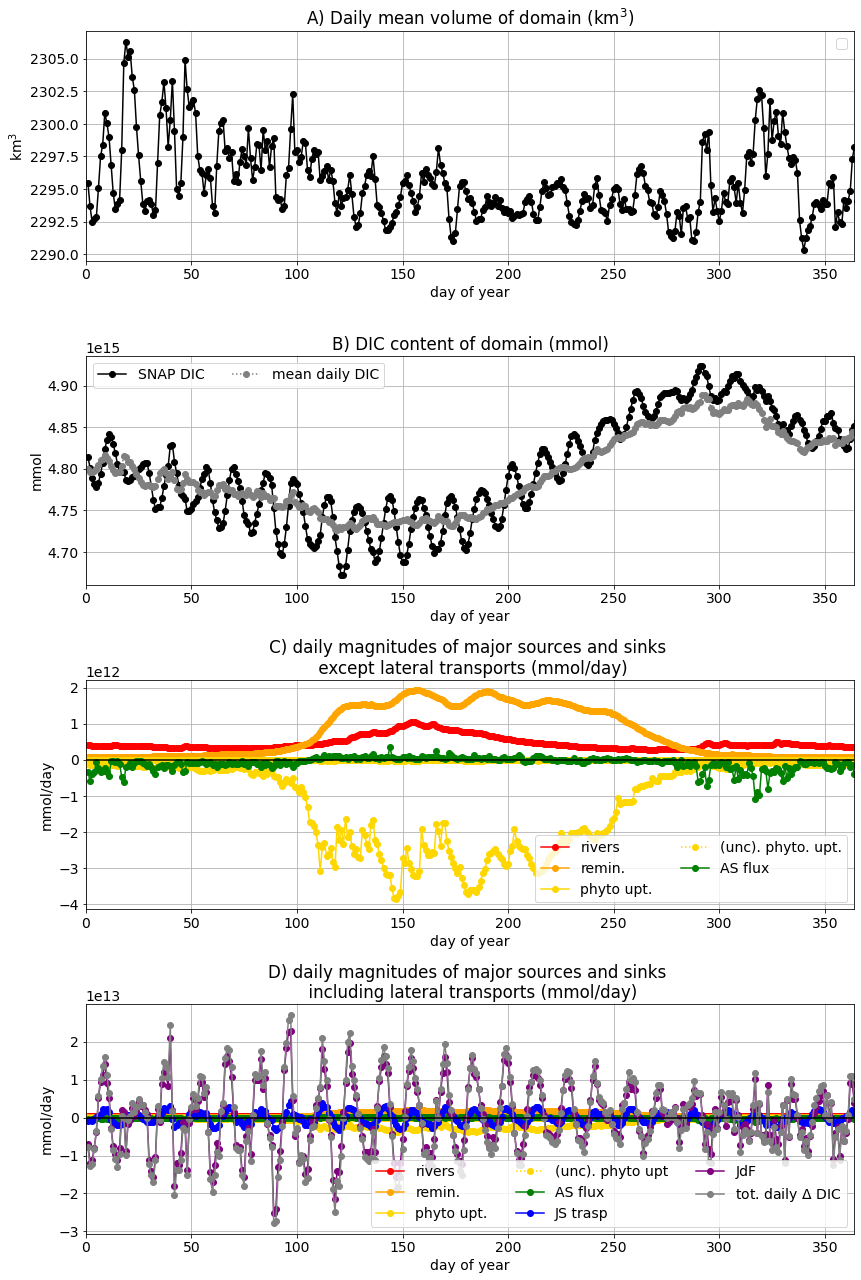

In [12]:
#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 15}

#VARIABLES
# vol_km3_tot_ar ; DIC_mmol_tot_ar 
# DIC_SNAP_mmol_tot_ar ; 
# riv_DIC_mmol_day_tot_ar ; PRD_DIC_mmol_day_tot_ar ; 
# UNC_DIC_mmol_day_tot_ar ; REM_DIC_mmol_day_tot_ar ; 
# DIC_UT_mmol_day_tot_ar ; DIC_VT_mmol_day_tot_ar ; 
# ASflux_mmol_day_tot_ar ; daychange_mmol_day_tot_ar 
#end = '2017-03-01'
w = nc.Dataset(f'NEWBUDGETVARS_RIVTA5_{start}-{end}.nc')
#w = nc.Dataset('BUDGETVARS_RIVTA5_2017-01-01-2017-03-01.nc')
# print(w)

## plotting
fact = 0.6
fig, axs = plt.subplots(4,1, figsize=(20*fact, 30*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
\
axs[0].plot(np.arange(1, dayslen+1,1),w['vol_km3_tot_ar'][:], color = 'k',linestyle = '-',  marker = 'o')
axs
axs[1].plot(np.arange(1, dayslen+1,1),w['DIC_SNAP_mmol_tot_ar'][:], color = 'k',linestyle = '-', marker = 'o', \
           label = 'SNAP DIC')
axs[1].plot(np.arange(1, dayslen+1,1),w['DIC_mmol_tot_ar'][:], color = 'grey',linestyle = ':', marker = 'o',\
             label = 'mean daily DIC')
#plot one to one line

axs[2].plot(np.arange(1, dayslen+1,1),w['riv_DIC_mmol_day_tot_ar'][:], color = 'r',linestyle = '-', marker = 'o', \
           label = 'rivers')

axs[2].plot(np.arange(1, dayslen+1,1),w['REM_DIC_mmol_day_tot_ar'][:], color = 'orange',linestyle = '-', marker = 'o', \
           label = 'remin.')

axs[2].plot(np.arange(1, dayslen+1,1),w['PRD_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = '-', marker = 'o', \
           label = 'phyto upt.')
axs[2].plot(np.arange(1, dayslen+1,1),w['UNC_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = ':', marker = 'o', \
           label = '(unc). phyto. upt.')

axs[2].plot(np.arange(1, dayslen+1,1),w['ASflux_mmol_day_tot_ar'][:], color = 'green',linestyle = '-', marker = 'o', \
           label = 'AS flux')

axs[2].axhline(y = 0, color = 'k')

# plt.yscale("log")
###
axs[3].plot(np.arange(1, dayslen+1,1),w['riv_DIC_mmol_day_tot_ar'][:], color = 'r',linestyle = '-', marker = 'o', \
           label = 'rivers')

axs[3].plot(np.arange(1, dayslen+1,1),w['REM_DIC_mmol_day_tot_ar'][:], color = 'orange',linestyle = '-', marker = 'o', \
           label = 'remin.')

axs[3].plot(np.arange(1, dayslen+1,1),w['PRD_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = '-', marker = 'o', \
           label = 'phyto upt.')
axs[3].plot(np.arange(1, dayslen+1,1),w['UNC_DIC_mmol_day_tot_ar'][:], color = 'gold',linestyle = ':', marker = 'o', \
           label = '(unc). phyto upt')

axs[3].plot(np.arange(1, dayslen+1,1),w['ASflux_mmol_day_tot_ar'][:], color = 'green',linestyle = '-', marker = 'o', \
           label = 'AS flux ')

axs[3].plot(np.arange(1, dayslen+1,1),w['DIC_VT_mmol_day_tot_ar'][:], color = 'blue',linestyle = '-', marker = 'o', \
           label = 'JS trasp')

axs[3].plot(np.arange(1, dayslen+1,1),w['DIC_UT_mmol_day_tot_ar'][:], color = 'purple',linestyle = '-', marker = 'o', \
           label = 'JdF')

axs[3].plot(np.arange(1, dayslen+1,1),w['daychange_mmol_day_tot_ar'][:], color = 'grey',linestyle = '-', marker = 'o', \
           label = 'tot. daily $\Delta$ DIC')


axs[0].set_title('A) Daily mean volume of domain (km$^3$)'); 
axs[1].set_title('B) DIC content of domain (mmol)'); 
axs[2].set_title('C) daily magnitudes of major sources and sinks \n except lateral transports (mmol/day)'); 
axs[3].set_title('D) daily magnitudes of major sources and sinks \n including lateral transports (mmol/day)'); 

axs[0].set_ylabel('km$^3$'); 
axs[1].set_ylabel('mmol'); 
axs[2].set_ylabel('mmol/day'); 
axs[3].set_ylabel('mmol/day'); 


axs[3].axhline(y = 0, color = 'k')
for i in range(0,4):
    axs[i].grid()
    
    axs[i].set_xlim([0,dayslen-1])
    axs[i].set_xlabel('day of year')
    axs[i].legend(loc = 'best', ncol = 2)
    
axs[3].legend(loc = 'best', ncol = 3)
#axs[2].legend(loc = 'best')
#axs[3].legend(bbox_to_anchor = [1 , 1 ], fontsize = 14, ncol = 1)
plt.tight_layout()

In [13]:
print(np.sum(w['ASflux_mmol_day_tot_ar'][:]))

-31181412000000.0


#### Phytoplankton uptake and uncoupled phytoplankton uptake

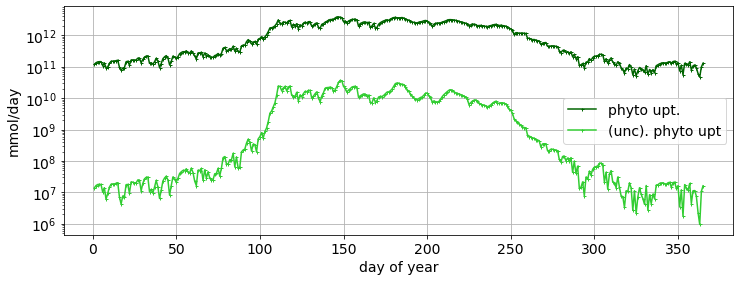

In [14]:
fact = 0.6
fig, axs = plt.subplots(1,1, figsize=(20*fact, 7*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()

axs.plot(np.arange(1, dayslen+1,1),-1*w['PRD_DIC_mmol_day_tot_ar'][:], color = 'darkgreen',linestyle = '-', marker = '+', markersize = 3,\
           label = 'phyto upt.')
axs.plot(np.arange(1, dayslen+1,1),-1*w['UNC_DIC_mmol_day_tot_ar'][:], color = 'limegreen',linestyle = '-', marker = '+', markersize = 3,\
           label = '(unc). phyto upt')


plt.yscale("log")
axs.grid()
axs.set_ylabel('mmol/day'); 
axs.set_xlabel('day of year'); 
plt.legend(loc = 'best')


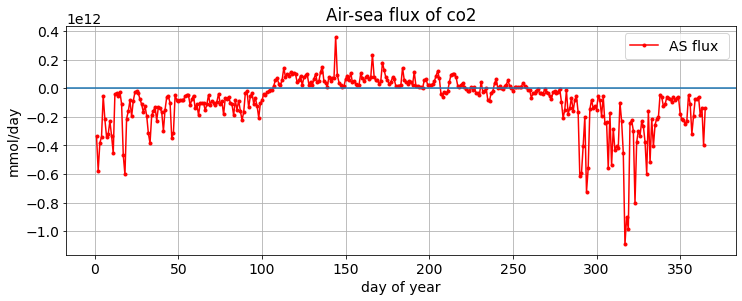

In [15]:
fact = 0.6
fig, axs = plt.subplots(1,1, figsize=(20*fact, 7*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# axs.plot(np.arange(1, dayslen+1,1),-1*w['PRD_DIC_mmol_day_tot_ar'][:], color = 'darkgreen',linestyle = '-', marker = '+', markersize = 3,\
#            label = 'phyto upt.')
# axs.plot(np.arange(1, dayslen+1,1),-1*w['UNC_DIC_mmol_day_tot_ar'][:], color = 'limegreen',linestyle = '-', marker = '+', markersize = 3,\
#            label = '(unc). phyto upt')

axs.plot(np.arange(1, dayslen+1,1),w['ASflux_mmol_day_tot_ar'][:], color = 'r',linestyle = '-', marker = '.', \
           label = 'AS flux ')

axs.axhline(y=0)
plt.title('Air-sea flux of co2')
#plt.yscale("log")
axs.grid()
axs.set_ylabel('mmol/day'); 
axs.set_xlabel('day of year'); 
plt.legend(loc = 'best')





In [16]:
print((w['DIC_mmol_tot_ar'][0]-w['DIC_mmol_tot_ar'][358])/w['DIC_mmol_tot_ar'][0])

-0.0076297233


In [17]:
print(w)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): days(365)
    variables(dimensions): float32 vol_km3_tot_ar(days), float32 DIC_mmol_tot_ar(days), float32 DIC_SNAP_mmol_tot_ar(days), float32 riv_DIC_mmol_day_tot_ar(days), float32 PRD_DIC_mmol_day_tot_ar(days), float32 UNC_DIC_mmol_day_tot_ar(days), float32 REM_DIC_mmol_day_tot_ar(days), float32 DIC_UT_mmol_day_tot_ar(days), float32 DIC_VT_mmol_day_tot_ar(days), float32 ASflux_mmol_day_tot_ar(days), float32 daychange_mmol_day_tot_ar(days), float32 DIC_VT_mmol_day_pos_ar(days), float32 DIC_VT_mmol_day_neg_ar(days), float32 DIC_UT_mmol_day_pos_ar(days), float32 DIC_UT_mmol_day_neg_ar(days), float32 DIC_ATX_mmol_day_pos_ar(days), float32 DIC_ATX_mmol_day_neg_ar(days), float32 DIC_ATY_mmol_day_pos_ar(days), float32 DIC_ATY_mmol_day_neg_ar(days), float32 DIC_DTX_mmol_day_pos_ar(days), float32 DIC_DTX_mmol_day_neg_ar(days), float32 DIC_DTY_mmol_day_pos_ar(days), float32 DIC_DTY_mmol_

In [18]:
print('amplitude of seas cycl')
tman = (np.nanmean(w['DIC_mmol_tot_ar'][:]*1e-15))
tran = np.nanmax(w['DIC_mmol_tot_ar'][:]*1e-15)-np.nanmin(w['DIC_mmol_tot_ar'][:]*1e-15)
print(tran)
print(tman)
print(tran/tman*100) 

print('positive air-sea flux')
asfl = w['ASflux_mmol_day_tot_ar'][:]
asfl_pos = np.nansum(asfl[asfl>0]*1e-15)
print(asfl_pos*1e3)
print('neg air-sea flux out')
asfl_neg = np.nansum(asfl[asfl<0])*1e-15
print(asfl_neg*1e3)



print('positive JDF in ')
pos_JDF = np.nansum(w['DIC_ATX_mmol_day_pos_ar'][:])*1e-15
print(pos_JDF)
print('negitive JDF out')
neg_JDF = np.nansum(w['DIC_ATX_mmol_day_neg_ar'][:])*1e-15
print(neg_JDF)

print('positive JS in')
pos_js = (np.nansum(w['DIC_ATY_mmol_day_pos_ar'][:])*1e-15)
print(pos_js)
print('negitive JS in')
neg_js = np.nansum(w['DIC_ATY_mmol_day_neg_ar'][:])*1e-15
print(neg_js)

print('remineralization')
rem = np.nansum(w['REM_DIC_mmol_day_tot_ar'][:])*1e-15
print(rem)

print('production')
prod = np.nansum(w['PRD_DIC_mmol_day_tot_ar'][:])*1e-15
print(prod)

print('riv')
riv = np.nansum(w['riv_DIC_mmol_day_tot_ar'][:])*1e-15
print(riv)


posflux = riv+rem+pos_js+pos_JDF+asfl_pos

print(f'total: {posflux}')
print(f'riv {riv/posflux*100}')
print(f'rem {rem/posflux*100}')
print(f'pos_js {pos_js/posflux*100}')
print(f'pos_JDF {pos_JDF/posflux*100}')
print(f'asfl_pos {asfl_pos/posflux*100}')

print()

negflux = prod+neg_js+neg_JDF+asfl_neg
print(f'total: {negflux}')
print(f'prod: {prod/posflux*100}')
print(f'neg_js {neg_js/negflux*100}')
print(f'neg_JDF {neg_JDF/negflux*100}')
print(f'asfl_neg {asfl_neg/negflux*100}')




amplitude of seas cycl
0.16278076
4.795405
3.3945154398679733
positive air-sea flux
7.354915142059326
neg air-sea flux out
-38.536329822208
positive JDF in 
12.01087067455488
negitive JDF out
-11.940641516814336
positive JS in
2.135128100831232
negitive JS in
-2.145738012229632
remineralization
0.27270173425664
production
-0.43714405308825605
riv
0.171614343790592
total: 14.597669768575404
riv 1.1756283469299222
rem 1.8681182584612828
pos_js 14.626499535066554
pos_JDF 82.2793696868718
asfl_pos 0.05038417267043778

total: -14.562059911954432
prod: -2.994615305172212
neg_js 14.73512693398639
neg_JDF 81.99829961564646
asfl_neg 0.2646351550207013


In [19]:
#1.18+1.87+14.63+82.28+0.05

82.00+3+14.74+0.26
#1.18+1.87+14.63+82.28+0.05

100.0

[1.2010871e+16, 2135128100000000.0, 272701730000000.0, 171614340000000.0, 7354914400000.0]


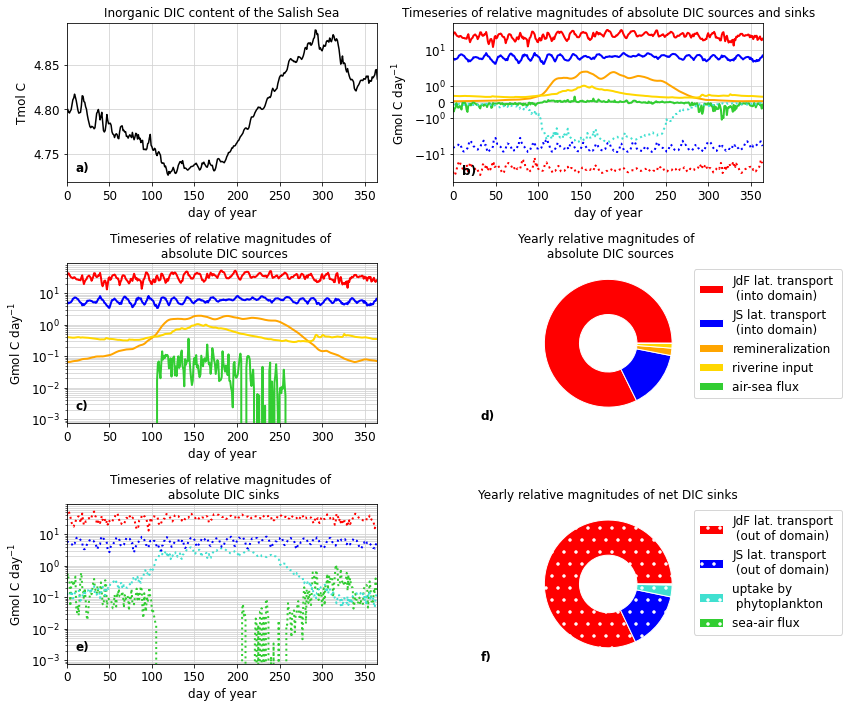

In [20]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 12}
lw = 2
fact = 0.4
days = np.arange(0,dayslen,1)
fig, axs = plt.subplots(3,2, figsize=(30*fact, 25*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(np.arange(1, dayslen+1,1),w['DIC_mmol_tot_ar'][:]*1e-15, color = 'k',linestyle = '-',\
             label = 'mean daily DIC')

axs[1].plot(days,w['DIC_ATX_mmol_day_pos_ar'][:]*1e-12, linestyle = '-', color = 'red', linewidth = lw, \
            label = 'lat. transp. of DIC into system, JDF') 
axs[1].plot(days,w['DIC_ATY_mmol_day_pos_ar'][:]*1e-12, linestyle = '-', color = 'blue', linewidth = lw, \
            label = 'lat. transp. of DIC into system, JS')
axs[1].plot(days,w['REM_DIC_mmol_day_tot_ar'][:]*1e-12, linestyle = '-', color = 'orange', linewidth = lw, \
            label = 'remineralization of DIC')
axs[1].plot(days,w['riv_DIC_mmol_day_tot_ar'][:]*1e-12, linestyle = '-', color = 'gold', linewidth = lw, \
            label = 'river input of DIC')
axs[1].plot(days,w['ASflux_mmol_day_tot_ar'][:]*1e-12, linestyle = '-', color = 'limegreen', linewidth = lw, \
            label = 'air-sea flux of CO2')
axs[1].plot(days,w['PRD_DIC_mmol_day_tot_ar'][:]*1e-12, linestyle = ':', color = 'turquoise', linewidth = lw, \
            label = 'uptake of DIC')
axs[1].plot(days,w['DIC_ATY_mmol_day_neg_ar'][:]*1e-12, linestyle = ':', color = 'blue', linewidth = lw, \
            label = 'lat. transp. of DIC out of system, JS')
axs[1].plot(days,w['DIC_ATX_mmol_day_neg_ar'][:]*1e-12, linestyle = ':', color = 'red', linewidth = lw, \
            label = 'lat. transp. of DIC out of system, JdF')
axs[1].set_yscale('symlog')

axs[2].plot(days,w['DIC_ATX_mmol_day_pos_ar'][:]*1e-12, linestyle = '-', color = 'red', linewidth = lw, \
            label = 'lat. transp. of DIC into system, JDF') 
axs[2].plot(days,w['DIC_ATY_mmol_day_pos_ar'][:]*1e-12, linestyle = '-', color = 'blue', linewidth = lw, \
            label = 'lat. transp. of DIC into system, JS')
axs[2].plot(days,w['REM_DIC_mmol_day_tot_ar'][:]*1e-12, linestyle = '-', color = 'orange', linewidth = lw, \
            label = 'remineralization of DIC')
axs[2].plot(days,w['riv_DIC_mmol_day_tot_ar'][:]*1e-12, linestyle = '-', color = 'gold', linewidth = lw, \
            label = 'river input of DIC')
axs[2].plot(days,w['ASflux_mmol_day_tot_ar'][:]*1e-12, linestyle = '-', color = 'limegreen', linewidth = lw, \
            label = 'air-sea flux of CO2')

axs[2].set_yscale('log')
axs[2].grid()



axs[0].grid(True, which="both", ls="-", color = 'lightgray')
axs[0].set_xlim([0,365])
axs[0].set_ylabel('Tmol C')
axs[0].set_xlabel('day of year')

axs[1].grid(True, which="both", ls="-", color = 'lightgray')
#axs[1].legend(bbox_to_anchor = [1, 1], ncol = 2)
axs[1].set_xlim([0,365])
axs[1].set_ylabel('Gmol C /day ')
axs[1].set_xlabel('day of year')

axs[2].grid(True, which="both", ls="-", color = 'lightgray')
axs[2].set_yscale('log')
axs[2].set_xlim([0,365])
axs[2].set_ylabel('Gmol C /day ')
axs[2].set_xlabel('day of year')

axs[4].plot(days,(-1)*w['ASflux_mmol_day_tot_ar'][:]*1e-12, linestyle = ':', color = 'limegreen', linewidth = lw, \
            label = 'river input of DIC')
axs[4].plot(days,(-1)*w['PRD_DIC_mmol_day_tot_ar'][:]*1e-12, linestyle = ':', color = 'turquoise', linewidth = lw, \
            label = 'uptake of DIC')
axs[4].plot(days,(-1)*w['DIC_ATY_mmol_day_neg_ar'][:]*1e-12, linestyle = ':', color = 'blue', linewidth = lw, \
            label = 'lat. transp. of DIC out of system, JS')
axs[4].plot(days,(-1)*w['DIC_ATX_mmol_day_neg_ar'][:]*1e-12, linestyle = ':', color = 'red', linewidth = lw, \
            label = 'lat. transp. of DIC out of system, JdF')

axs[4].grid(True, which="both", ls="-", color = 'lightgray')
axs[4].set_yscale('log')
axs[4].set_xlim([0,365])
axs[4].set_ylabel('Gmol C day$^{-1}$')
axs[4].set_xlabel('day of year')


axs[1].set_ylabel('Gmol C day$^{-1}$')
axs[2].set_ylabel('Gmol C day$^{-1}$')
axs[4].set_ylabel('Gmol C day$^{-1}$')





###
size = 0.55
asflux = w['ASflux_mmol_day_tot_ar'][:]
posflux = asflux[asflux>0]
vals = [np.nansum(w['DIC_ATX_mmol_day_pos_ar'][:]),\
       np.nansum(w['DIC_ATY_mmol_day_pos_ar'][:]),\
       np.nansum(w['REM_DIC_mmol_day_tot_ar'][:]),\
       np.nansum(w['riv_DIC_mmol_day_tot_ar'][:]),\
       np.nansum(posflux)]

print(vals)
                 
cmap = plt.get_cmap("tab20c")
outer_colors = ['red','blue','orange','gold','limegreen']
inner_colors = cmap([1, 2, 5, 6, 9, 10])
labels = ['JdF lat. transport \n (into domain)','JS lat. transport \n (into domain)',\
          'remineralization','riverine input','air-sea flux']

axs[3].pie(vals, radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))
axs[3].legend(labels, bbox_to_anchor=(1, 0, 0.5, 1))
# ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))


####



asflux = w['ASflux_mmol_day_tot_ar'][:]
negflux = asflux[asflux<0]
vals = [-1*np.nansum(w['DIC_ATX_mmol_day_neg_ar'][:]),\
       -1*np.nansum(w['DIC_ATY_mmol_day_neg_ar'][:]),\
       -1*np.nansum(w['PRD_DIC_mmol_day_tot_ar'][:]),\
       -1*np.nansum(negflux)]
labels = ['JdF lat. transport \n (out of domain)','JS lat. transport \n (out of domain)','uptake by \n phytoplankton','sea-air flux']

cmap = plt.get_cmap("tab20c")
outer_colors = ['red','blue','turquoise','limegreen']
inner_colors = cmap([1, 2, 5, 6, 9, 10])

axs[5].pie(vals, radius=1, colors=outer_colors, 
       wedgeprops=dict(width=size, edgecolor='w', hatch = '.'))
axs[5].legend(labels, bbox_to_anchor=(1, 0, 0.5, 1))

#bbox_to_anchor=(1, 0, 0.5, 1)



axs[0].set_title('Inorganic DIC content of the Salish Sea', fontsize = 12)
axs[1].set_title('Timeseries of relative magnitudes of absolute DIC sources and sinks', fontsize = 12)
axs[2].set_title('Timeseries of relative magnitudes of \n absolute DIC sources', fontsize = 12)
axs[3].set_title('Yearly relative magnitudes of \n absolute DIC sources', fontsize = 12)
axs[4].set_title('Timeseries of relative magnitudes of \n absolute DIC sinks', fontsize = 12)
axs[5].set_title('Yearly relative magnitudes of net DIC sinks', fontsize = 12)



axs[0].text(10, 4.73, 'a)', fontsize = 12, weight = 'bold')
axs[1].text(10, -51, 'b)', fontsize = 12, weight = 'bold')
axs[2].text(10, 0.002, 'c)', fontsize = 12, weight = 'bold')
axs[3].text(-2, -1.2, 'd)', fontsize = 12, weight = 'bold')
axs[4].text(10, 0.002, 'e)', fontsize = 12, weight = 'bold')
axs[5].text(-2, -1.2, 'f)', fontsize = 12, weight = 'bold')

plt.tight_layout()
#plt.suptitle('Mean transport of carbon through the SalishSeaCast boundaries by yearday', fontsize = 18)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


[1.2010871e+16, 2135128100000000.0, 272701730000000.0, 171614340000000.0, 7354914400000.0]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


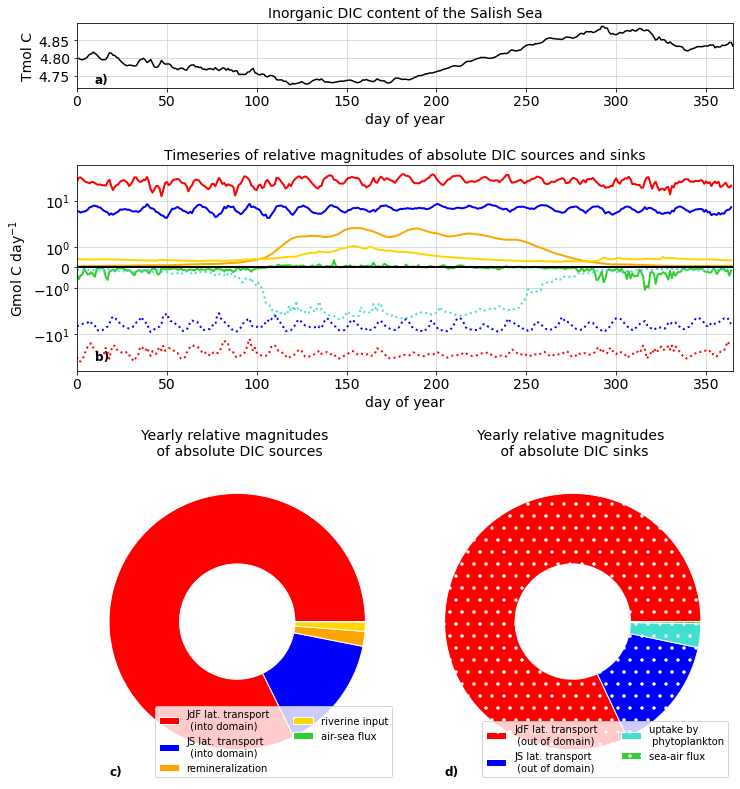

In [21]:
fact = 0.35
fig = plt.figure(figsize=(30*fact, 32.5*fact), facecolor='w', edgecolor='k')
lw = 2

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

##### total carbon concentration 
ax1 = plt.subplot2grid((6, 4), (0, 0), colspan=4)
ax1.plot(np.arange(1, dayslen+1,1),w['DIC_mmol_tot_ar'][:]*1e-15, color = 'k',linestyle = '-',\
             label = 'mean daily DIC')
ax1.grid(True, which="both", ls="-", color = 'lightgray')
ax1.set_xlim([0,365])
ax1.set_ylabel('Tmol C')
ax1.set_xlabel('day of year')
ax1.set_title('Inorganic DIC content of the Salish Sea', fontsize = 14)
ax1.text(10, 4.73, 'a)', fontsize = 12, weight = 'bold')

### sources and sinks
ax2 = plt.subplot2grid((6, 4), (1, 0), colspan=4, rowspan = 2)
ax2.plot(days,w['DIC_ATX_mmol_day_pos_ar'][:]*1e-12, linestyle = '-', color = 'red', linewidth = lw, \
            label = 'lat. transp. of DIC into system, JDF') 
ax2.plot(days,w['DIC_ATY_mmol_day_pos_ar'][:]*1e-12, linestyle = '-', color = 'blue', linewidth = lw, \
            label = 'lat. transp. of DIC into system, JS')
ax2.plot(days,w['REM_DIC_mmol_day_tot_ar'][:]*1e-12, linestyle = '-', color = 'orange', linewidth = lw, \
            label = 'remineralization of DIC')
ax2.plot(days,w['riv_DIC_mmol_day_tot_ar'][:]*1e-12, linestyle = '-', color = 'gold', linewidth = lw, \
            label = 'river input of DIC')
ax2.plot(days,w['ASflux_mmol_day_tot_ar'][:]*1e-12, linestyle = '-', color = 'limegreen', linewidth = lw, \
            label = 'air-sea flux of CO2')
ax2.plot(days,w['PRD_DIC_mmol_day_tot_ar'][:]*1e-12, linestyle = ':', color = 'turquoise', linewidth = lw, \
            label = 'uptake of DIC')
ax2.plot(days,w['DIC_ATY_mmol_day_neg_ar'][:]*1e-12, linestyle = ':', color = 'blue', linewidth = lw, \
            label = 'lat. transp. of DIC out of system, JS')
ax2.plot(days,w['DIC_ATX_mmol_day_neg_ar'][:]*1e-12, linestyle = ':', color = 'red', linewidth = lw, \
            label = 'lat. transp. of DIC out of system, JdF')
ax2.set_yscale('symlog')
ax2.axhline(y=0, color = 'k', linewidth = 2)
ax2.grid(True, which="both", ls="-", color = 'lightgray')
#ax2.legend(bbox_to_anchor = [1, 1], ncol = 2)
ax2.set_xlim([0,365])
ax2.set_xlabel('day of year')
ax2.set_ylabel('Gmol C day$^{-1}$')
ax2.set_title('Timeseries of relative magnitudes of absolute DIC sources and sinks', fontsize = 14)
ax2.text(10, -51, 'b)', fontsize = 12, weight = 'bold')



ax3 = plt.subplot2grid((6, 4), (3, 0), rowspan=3, colspan = 2)
size = 0.55
asflux = w['ASflux_mmol_day_tot_ar'][:]
posflux = asflux[asflux>0]
vals = [np.nansum(w['DIC_ATX_mmol_day_pos_ar'][:]),\
       np.nansum(w['DIC_ATY_mmol_day_pos_ar'][:]),\
       np.nansum(w['REM_DIC_mmol_day_tot_ar'][:]),\
       np.nansum(w['riv_DIC_mmol_day_tot_ar'][:]),\
       np.nansum(posflux)]

print(vals)
                 
cmap = plt.get_cmap("tab20c")
outer_colors = ['red','blue','orange','gold','limegreen']
inner_colors = cmap([1, 2, 5, 6, 9, 10])
labels = ['JdF lat. transport \n (into domain)','JS lat. transport \n (into domain)',\
          'remineralization','riverine input','air-sea flux']

ax3.pie(vals, radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))
ax3.legend(labels, loc = 4, ncol = 2, fontsize = 10)
ax3.set_title('Yearly relative magnitudes \n of absolute DIC sources',fontsize = 14)
ax3.text(-1, -1.2, 'c)', fontsize = 12, weight = 'bold')




ax4 = plt.subplot2grid((6, 4), (3, 2), rowspan=3, colspan = 2)
asflux = w['ASflux_mmol_day_tot_ar'][:]
negflux = asflux[asflux<0]
vals = [-1*np.nansum(w['DIC_ATX_mmol_day_neg_ar'][:]),\
       -1*np.nansum(w['DIC_ATY_mmol_day_neg_ar'][:]),\
       -1*np.nansum(w['PRD_DIC_mmol_day_tot_ar'][:]),\
       -1*np.nansum(negflux)]
labels = ['JdF lat. transport \n (out of domain)','JS lat. transport \n (out of domain)','uptake by \n phytoplankton','sea-air flux']

cmap = plt.get_cmap("tab20c")
outer_colors = ['red','blue','turquoise','limegreen']
inner_colors = cmap([1, 2, 5, 6, 9, 10])

ax4.pie(vals, radius=1, colors=outer_colors, 
       wedgeprops=dict(width=size, edgecolor='w', hatch = '.'))
ax4.legend(labels, loc = 4, ncol = 2, fontsize = 10)
ax4.set_title('Yearly relative magnitudes \n of absolute DIC sinks',fontsize = 14)
ax4.text(-1, -1.2, 'd)', fontsize = 12, weight = 'bold')




plt.tight_layout()

In [22]:
tot = w['DIC_mmol_tot_ar'][:]*1e-15
# print(np.max(tot))

print(tot[0])
print(tot[364])
(4.83-4.8)/4.8

4.7996454
4.8338475


0.006250000000000052

In [23]:
print(np.nansum(w['REM_DIC_mmol_day_tot_ar'][90:300]) + np.nansum(w['riv_DIC_mmol_day_tot_ar'][90:300]))

print(np.nansum(w['PRD_DIC_mmol_day_tot_ar'][90:300]))


368553020000000.0
-410287900000000.0


In [24]:
vals = [np.nansum(w['DIC_ATX_mmol_day_pos_ar'][:]),\
       np.nansum(w['DIC_ATY_mmol_day_pos_ar'][:]),\
       np.nansum(w['REM_DIC_mmol_day_tot_ar'][:]),\
       np.nansum(w['riv_DIC_mmol_day_tot_ar'][:]),\
       np.nansum(posflux)]

print(vals)
print(np.nansum(w['DIC_ATX_mmol_day_pos_ar'][:])/np.nansum(w['DIC_ATY_mmol_day_pos_ar'][:]))
print((np.nansum(w['DIC_ATX_mmol_day_pos_ar'][:])+ (np.nansum(w['DIC_ATY_mmol_day_pos_ar'][:]))) /np.nansum(vals))

print(np.nansum(w['REM_DIC_mmol_day_tot_ar'][:])/np.nansum(vals))
print(np.nansum(w['riv_DIC_mmol_day_tot_ar'][:])/np.nansum(vals))
print((np.nansum(posflux) /np.nansum(vals)))

vals = [-1*np.nansum(w['DIC_ATX_mmol_day_neg_ar'][:]),\
       -1*np.nansum(w['DIC_ATY_mmol_day_neg_ar'][:]),\
       -1*np.nansum(w['PRD_DIC_mmol_day_tot_ar'][:]),\
       -1*np.nansum(negflux)]

print(np.nansum(w['DIC_ATX_mmol_day_neg_ar'][:])/np.nansum(w['DIC_ATY_mmol_day_neg_ar'][:]))
print((np.nansum(w['DIC_ATX_mmol_day_neg_ar'][:])+ (np.nansum(w['DIC_ATY_mmol_day_neg_ar'][:]))) /np.nansum(vals))
print((np.nansum(negflux) /np.nansum(vals)))


[1.2010871e+16, 2135128100000000.0, 272701730000000.0, 171614340000000.0, 7354914400000.0]
5.625363
0.9690587
0.018681183
0.011756284
0.0005038417
5.564818
-0.9673342470624352
-0.0026463515502070122


In [25]:
print(w)
mmol_to_tmol = 1e-15
mmol_to_gmol = 1e-12
print('jdf in')
print(np.sum(w['DIC_ATX_mmol_day_pos_ar'][:])*mmol_to_tmol)
print('jdf out')
print(np.sum(w['DIC_ATX_mmol_day_neg_ar'][:])*mmol_to_tmol)
print('js in ')
print(np.sum(w['DIC_ATY_mmol_day_pos_ar'][:])*mmol_to_tmol)
print('js out')
print(np.sum(w['DIC_ATY_mmol_day_neg_ar'][:])*mmol_to_tmol)
print('rivers in')
print(np.sum(w['riv_DIC_mmol_day_tot_ar'][:])*mmol_to_tmol)
print('prod (out)')
print(np.sum(w['PRD_DIC_mmol_day_tot_ar'][:])*mmol_to_tmol)
print('prod (uncoupled carbon)')
print(np.sum(w['UNC_DIC_mmol_day_tot_ar'][:])*mmol_to_tmol)
print('rem (in)')
print(np.sum(w['REM_DIC_mmol_day_tot_ar'][:])*mmol_to_tmol)
print('as_flux')
asflux = w['ASflux_mmol_day_tot_ar'][:]
negflux = asflux[asflux<0]
posflux = asflux[asflux>0]
print(np.sum(negflux)*mmol_to_gmol)
print(np.sum(posflux)*mmol_to_gmol)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): days(365)
    variables(dimensions): float32 vol_km3_tot_ar(days), float32 DIC_mmol_tot_ar(days), float32 DIC_SNAP_mmol_tot_ar(days), float32 riv_DIC_mmol_day_tot_ar(days), float32 PRD_DIC_mmol_day_tot_ar(days), float32 UNC_DIC_mmol_day_tot_ar(days), float32 REM_DIC_mmol_day_tot_ar(days), float32 DIC_UT_mmol_day_tot_ar(days), float32 DIC_VT_mmol_day_tot_ar(days), float32 ASflux_mmol_day_tot_ar(days), float32 daychange_mmol_day_tot_ar(days), float32 DIC_VT_mmol_day_pos_ar(days), float32 DIC_VT_mmol_day_neg_ar(days), float32 DIC_UT_mmol_day_pos_ar(days), float32 DIC_UT_mmol_day_neg_ar(days), float32 DIC_ATX_mmol_day_pos_ar(days), float32 DIC_ATX_mmol_day_neg_ar(days), float32 DIC_ATY_mmol_day_pos_ar(days), float32 DIC_ATY_mmol_day_neg_ar(days), float32 DIC_DTX_mmol_day_pos_ar(days), float32 DIC_DTX_mmol_day_neg_ar(days), float32 DIC_DTY_mmol_day_pos_ar(days), float32 DIC_DTY_mmol_

## how much of increase from day ~ 100 to day ~300 is remineralization?




In [26]:
diff = w['DIC_mmol_tot_ar'][300]-w['DIC_mmol_tot_ar'][100]
print(f'increase in domain DIC between day 100-300, Gmol: {diff*1e-12}')

remin = np.sum(w['REM_DIC_mmol_day_tot_ar'][100:300])
prod = np.sum(w['PRD_DIC_mmol_day_tot_ar'][100:300])
riv = np.sum(w['riv_DIC_mmol_day_tot_ar'][100:300])
print(f'remineralization of DIC between day 100-300, Gmol: {remin*1e-12}')
print(f'uptake of DIC between day 100-300, Gmol: {prod*1e-12}')
print(f'river delivery of DIC between day 100-300, Gmol: {riv*1e-12}')
print(f'remin+uptake of DIC between day 100-300, Gmol: {(remin+prod)*1e-12}')
print(f'remin+uptake+riv of DIC between day 100-300, Gmol: {(remin+prod+riv)*1e-12}')

increase in domain DIC between day 100-300, Gmol: 113.75220883456
remineralization of DIC between day 100-300, Gmol: 252.868917460992
uptake of DIC between day 100-300, Gmol: -403.99066365952
river delivery of DIC between day 100-300, Gmol: 108.88497908940799
remin+uptake of DIC between day 100-300, Gmol: -151.121746198528
remin+uptake+riv of DIC between day 100-300, Gmol: -42.23676710912


[1.2010871e+16, 2135128100000000.0, 272701730000000.0, 171614340000000.0, 7354914400000.0]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


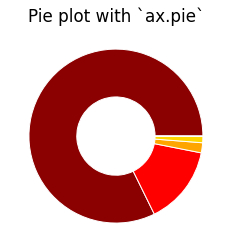

In [27]:
# axs[2].plot(days,w['DIC_ATX_mmol_day_pos_ar'][:], linestyle = '-', color = 'darkred', linewidth = lw, \
#             label = 'lat. transp. of DIC into system, JDF') 
# axs[2].plot(days,w['DIC_ATY_mmol_day_pos_ar'][:], linestyle = '-', color = 'red', linewidth = lw, \
#             label = 'lat. transp. of DIC into system, JS')
# axs[2].plot(days,w['REM_DIC_mmol_day_tot_ar'][:], linestyle = '-', color = 'orange', linewidth = lw, \
#             label = 'remineralization of DIC')
# axs[2].plot(days,w['riv_DIC_mmol_day_tot_ar'][:], linestyle = '-', color = 'gold', linewidth = lw, \
#             label = 'river input of DIC')
# axs[2].plot(days,w['ASflux_mmol_day_tot_ar'][:], linestyle = '-', color = 'limegreen', linewidth = lw, \
#             label = 'air-sea flux of CO2')


fig, ax = plt.subplots()

size = 0.55
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

vals = [3,4,5]

asflux = w['ASflux_mmol_day_tot_ar'][:]
posflux = asflux[asflux>0]
vals = [np.nansum(w['DIC_ATX_mmol_day_pos_ar'][:]),\
       np.nansum(w['DIC_ATY_mmol_day_pos_ar'][:]),\
       np.nansum(w['REM_DIC_mmol_day_tot_ar'][:]),\
       np.nansum(w['riv_DIC_mmol_day_tot_ar'][:]),\
       np.nansum(posflux)]

print(vals)
                 
cmap = plt.get_cmap("tab20c")
outer_colors = ['darkred','red','orange','gold','limegreen']
inner_colors = cmap([1, 2, 5, 6, 9, 10])

ax.pie(vals, radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

# ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

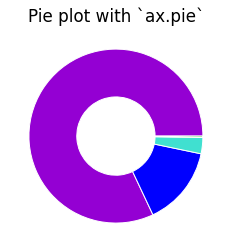

In [28]:
# axs[4].plot(days,(-1)*w['ASflux_mmol_day_tot_ar'][:], linestyle = '-', color = 'limegreen', linewidth = lw, \
#             label = 'river input of DIC')
# axs[4].plot(days,(-1)*w['PRD_DIC_mmol_day_tot_ar'][:], linestyle = '-', color = 'turquoise', linewidth = lw, \
#             label = 'uptake of DIC')
# axs[4].plot(days,(-1)*w['DIC_ATY_mmol_day_neg_ar'][:], linestyle = '-', color = 'blue', linewidth = lw, \
#             label = 'lat. transp. of DIC out of system, JS')
# axs[4].plot(days,(-1)*w['DIC_ATX_mmol_day_neg_ar'][:], linestyle = '-', color = 'darkviolet', linewidth = lw, \
#             label = 'lat. transp. of DIC out of system, JdF')


fig, ax = plt.subplots()


vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

vals = [3,4,5]
size = 0.55
asflux = w['ASflux_mmol_day_tot_ar'][:]
negflux = asflux[asflux<0]
vals = [-1*np.nansum(w['DIC_ATX_mmol_day_neg_ar'][:]),\
       -1*np.nansum(w['DIC_ATY_mmol_day_neg_ar'][:]),\
       -1*np.nansum(w['PRD_DIC_mmol_day_tot_ar'][:]),\
       -1*np.nansum(negflux)]
                 
cmap = plt.get_cmap("tab20c")
outer_colors = ['darkviolet','blue','turquoise','limegreen']
inner_colors = cmap([1, 2, 5, 6, 9, 10])

ax.pie(vals, radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

## Comentary:

- A) Daily mean domain volume. It changes quite a bit (even with higher-frequency tides largely filtered out in this view); maximum ~  (2290-2275)/2275 = 0.65%. SNAP volume (instantaneous volume taken at a consistent point in day) would (likely) show even larger amplitude variability
- B) DIC content of the domain: SNAP and mean daily
        - SNAP is "instantaneous at midnight, for a given day, calculated by XIOS as "([instantaneous DIC at midnight] * [instantaneous e3t at midnight])"
        - mean daily DIC is calculated as [daily mean DIC concentration] * [daily mean e3t])
- B) As expected, the SNAP content has larger amplitudes due to not filtering out high-frequency tide cycles. DIC content is decreasing, which makes sense for the time of year - lots of carbon is leaving the surface, the deep waters have a lower carbon content due to downwelling. 
- C) Magnitudes of sources and sinks except lateral fluxes - riverine DIC input is always a source, as is remineralization, phytoplankton uptake is a sink, uncoupled carbon uptake by phyto is (so far, in winter) 4 orders of magnitude lower (1e7 mmol/day vs 1e11 mmol/day) than normal phyto uptake, AS flux is a sink but we expect it to turn to a source in summer. AS flux shows the largest amplitude of variability. 
- D) All sources and sinks. JdF fluxes dwarf everything, JS is second in magnitude (basically expected) 

### checking that the budget adds up.


- **DIC_E3TSNAP** gives instantaneous DIC concentration * e3t at the end of the day.
- we use it to calculate **DIC_SNAP_mmol_tot_ar** - instantaneous total carbon content of the domain at the end of the day
- we also add all the sources and sinks from the model to give us **daychange_mmol_day_tot_ar**.
- The change in the model carbon content should be the sum of the carbon sources and the sinks
- So, (**DIC_SNAP_mmol_tot_ar[jan 2]** - **DIC_SNAP_mmol_tot_ar[jan 1]**) should be equal to  **daychange_mmol_day_tot_ar[jan 2]**
- we can plot every day's change in **DIC_SNAP_mmol_tot_ar** (called **SNAP_diff**)  against **daychange_mmol_day_tot_ar** - must be careful with off-by-one-day errors, but these should be equal. We do not have **SNAP_diff** for jan 1, as we do not know instantaneous carbon content at end of Dec 31, 2016. 
- we can also plot DIC_SNAP_mmol_tot_ar[jan 1] + the sum of the subsequent days' daily differences against **DIC_SNAP_mmol_tot_ar** to see if these line up



In [29]:
daily_diff = w['daychange_new_mmol_day_tot_ar'][:]
daily_SNAP = w['DIC_SNAP_mmol_tot_ar'][:]

print(np.shape(daily_diff))

SNAP_diff = np.zeros_like(daily_SNAP)
day1_SNAP_plus_cum_diff = np.zeros_like(daily_diff)


day1_SNAP_plus_cum_diff[0] = daily_SNAP[0]

for i in range(1,dayslen):
    
    day1_SNAP_plus_cum_diff[i] = \
    day1_SNAP_plus_cum_diff[0] + np.nansum(daily_diff[1:i+1])
    
day1_SNAP_plus_cum_diff[day1_SNAP_plus_cum_diff == 0 ] = np.nan


for i in range(1,dayslen):
    SNAP_diff[i] = daily_SNAP[i] - daily_SNAP[i-1]
    
SNAP_diff[0] = np.nan

print(np.shape(SNAP_diff))
print(dayslen)

(365,)
(365,)
365


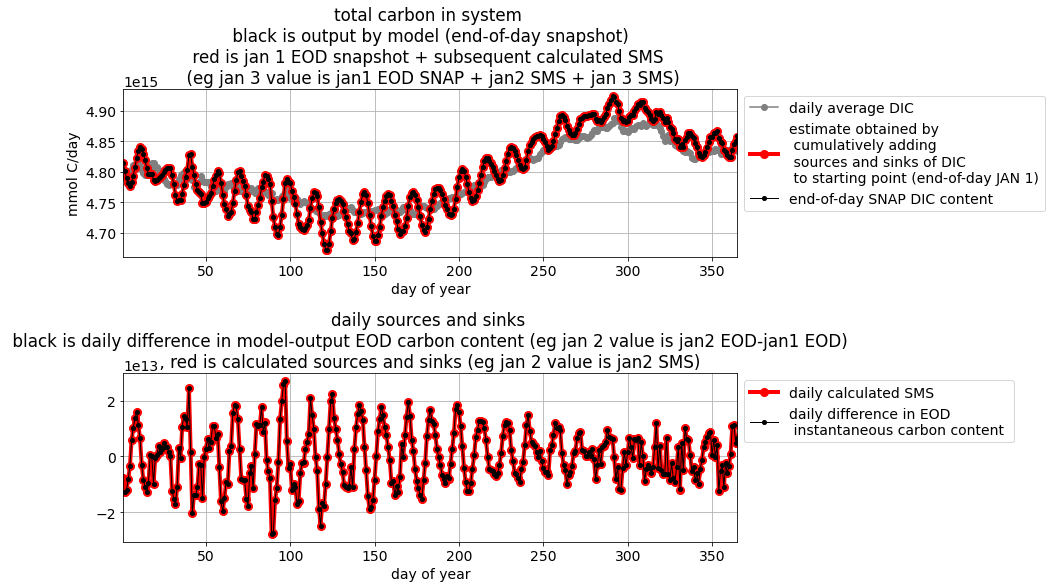

In [30]:
fact = 0.7
fig, axs = plt.subplots(2,1, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(np.arange(1,dayslen+1,1),w['DIC_mmol_tot_ar'][:], color = 'grey',linestyle = '-',  marker = 'o', \
           label = 'daily average DIC ')

axs[0].plot(np.arange(1,dayslen+1,1),day1_SNAP_plus_cum_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, \
           label = 'estimate obtained by \n cumulatively adding \n sources and sinks of DIC \n to starting point (end-of-day JAN 1)')
axs[0].plot(np.arange(1,dayslen+1,1),w['DIC_SNAP_mmol_tot_ar'][:], color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4,\
           label = 'end-of-day SNAP DIC content')
axs[0].legend(bbox_to_anchor = [1, 1])


axs[1].plot(np.arange(1,dayslen+1,1),daily_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, label = 'daily calculated SMS')
axs[1].plot(np.arange(1,dayslen+1,1),SNAP_diff, color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4, label = 'daily difference in EOD \n instantaneous carbon content ')

axs[0].set_title('total carbon in system \n black is output by model (end-of-day snapshot) \n red is jan 1 EOD snapshot + subsequent calculated SMS  \n (eg jan 3 value is jan1 EOD SNAP + jan2 SMS + jan 3 SMS)')
axs[1].set_title('daily sources and sinks \n black is daily difference in model-output EOD carbon content (eg jan 2 value is jan2 EOD-jan1 EOD) \n , red is calculated sources and sinks (eg jan 2 value is jan2 SMS) ')
axs[0].set_ylabel('mmol C')
axs[0].set_ylabel('mmol C/day')

for i in range(0,2):
    axs[i].grid();
    axs[i].set_xlabel('day of year')
    axs[i].set_xlim([1,dayslen])
    axs[i].legend(bbox_to_anchor = [1 ,1])
plt.tight_layout()


####  Visually these estimates seem to line up very well; quantitatively, how close are they?

Let's look at the percent difference in the total carbon content calculated 2 ways, and also at the percent difference in implied SMS (difference in EOD reported values by E3TSNAP from day to day) and the calculated daily SMS. 

The total difference in the total carbon content calculated 2 ways is small (order 1/100 of a %) but potentially increasing. 
  

No handles with labels found to put in legend.
No handles with labels found to put in legend.


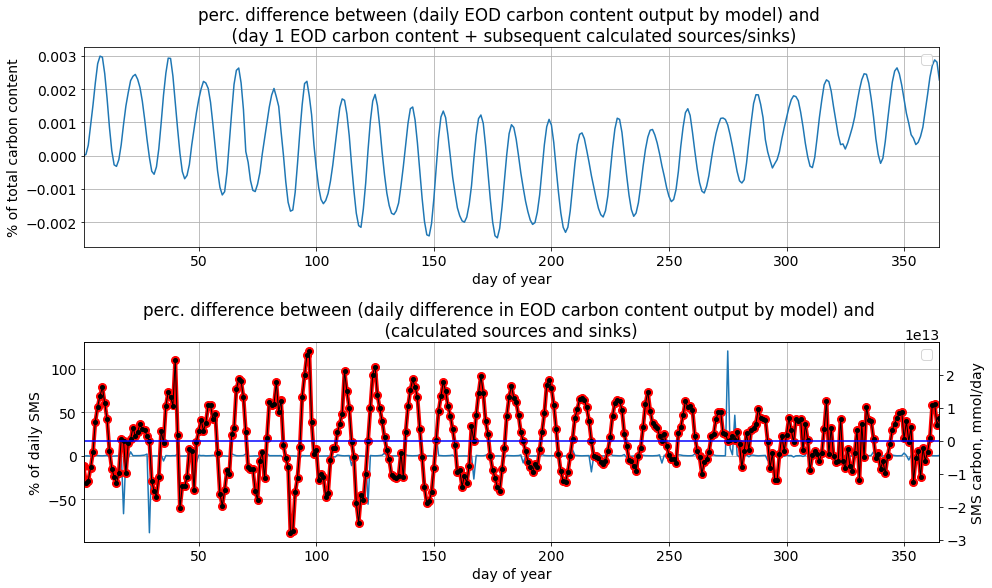

In [31]:
fact = 0.7
fig, axs = plt.subplots(2,1, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

SNAPest = w['DIC_SNAP_mmol_tot_ar'][:]
SMSest = day1_SNAP_plus_cum_diff

axs[0].plot(np.arange(1,dayslen+1,1), (((SNAPest)-(SMSest)))/((SNAPest+SMSest)/2) *100)

SNAPest = SNAP_diff
SMSest = daily_diff

axs[1].plot(np.arange(1,dayslen+1,1), np.abs(SNAPest-SMSest)/((SNAPest+SMSest)/2) *100)


ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
#ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.plot(np.arange(1,dayslen+1,1),daily_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, label = 'daily calculated SMS')
ax2.plot(np.arange(1,dayslen+1,1),SNAP_diff, color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4, label = 'daily difference in EOD \n instantaneous carbon content ')
ax2.plot(np.arange(1,dayslen+1,1),np.zeros_like(SNAP_diff), color = 'b')
ax2.set_ylabel('SMS carbon, mmol/day')
# axs[1].plot(np.arange(1,dayslen+1,1),daily_diff, color = 'r',linestyle = '-', linewidth = 4, marker = 'o', markersize = 8, label = 'daily calculated SMS')
# axs[1].plot(np.arange(1,dayslen+1,1),SNAP_DIFF, color = 'k',linestyle = '-', linewidth = 1, marker = 'o', markersize = 4, label = 'daily difference in EOD \n instantaneous carbon content ')

axs[0].set_title('perc. difference between (daily EOD carbon content output by model) and \n (day 1 EOD carbon content + subsequent calculated sources/sinks)')
axs[1].set_title('perc. difference between (daily difference in EOD carbon content output by model) and \n (calculated sources and sinks) ')
axs[0].set_ylabel('% of total carbon content')
axs[1].set_ylabel('% of daily SMS')

for i in range(0,2):
    axs[i].grid();
    axs[i].set_xlabel('day of year')
    axs[i].set_xlim([1,dayslen])
    axs[i].legend(bbox_to_anchor = [1 ,1])
plt.tight_layout()


## So, how close is our budget?

In most cases, the calculated sources and sinks are at least visually quite similar, as we can see. The mean magnitude of teh sources and sinks (mean of abs(SMS)) is ~8.21362108E+12. The large spikes in percent difference (shown above in blue) occur when the net sources and sinks are close to 0 (and sometimes on the opposite sides of 0). Disregarding where |SMS| < 1e12, the mean % difference is 0.987%. The mean difference between the 2 ways of calculating the sources and the sinks, not disregarding small sources and sinks, is 3%.  This is close, but is it close enough?


In [32]:
SNAPest = SNAP_diff
SMSest = daily_diff

#print(np.sort((daily_diff)))
mean_mag = (np.mean(np.abs(daily_diff[1:-1])))
print('mean calculated daily |SMS| (mmol/day):')
print(f"{Decimal(int(mean_mag)):.8E}") 
print('mean daily |SMS|from snap differences(mmol/day):')
print(f"{Decimal(int(np.nanmean(np.abs(SNAP_diff[1:-1])))):.8E}") 
print('')
#print(np.sort(daily_diff))

percdiff = np.abs(SNAPest-SMSest)/((SNAPest+SMSest)/2) *100
print('mean % diff between SMS calculated and SMS from SNAP')
print(np.mean(percdiff))             
# print('mean % diff disregarding small SMS (  |SMS| < 1e12 mmol/day)')
# percdiff[daily_diff < 1e12] = np.nan
# print(np.nanmean(percdiff))    

# #print(np.abs(SNAPest-SMSest)/((SNAPest+SMSest)/2) *100)

# SNAPest = np.sum(SNAP_diff[1:-1])
# SMSest = np.sum(daily_diff[1:-1]) 

# print('sum total SMS over timeperiod SNAP')
# print(f"{Decimal(int(SNAPest)):.8E}") 
# print('sum total SMS over timeperiod calculated')
# print(f"{Decimal(int(SMSest)):.8E}") 
# percdiff_total = np.abs(np.abs(SNAPest-SMSest)/((SNAPest+SMSest)/2)) *100
# print('% difference in the above two numbers ' )
# print(percdiff_total)


mean calculated daily |SMS| (mmol/day):
7.91458722E+12
mean daily |SMS|from snap differences(mmol/day):
7.91538932E+12

mean % diff between SMS calculated and SMS from SNAP
-0.15583335960304345


## Could the 'missing flux' be lateral diffusion?

Coefficient of lateral diffusion:
1.5 m2/s

total lateral diffusion (mmol/day) = coeff_ld * ∇ DIC * cross-sectional area * seconds/day



No handles with labels found to put in legend.
No handles with labels found to put in legend.


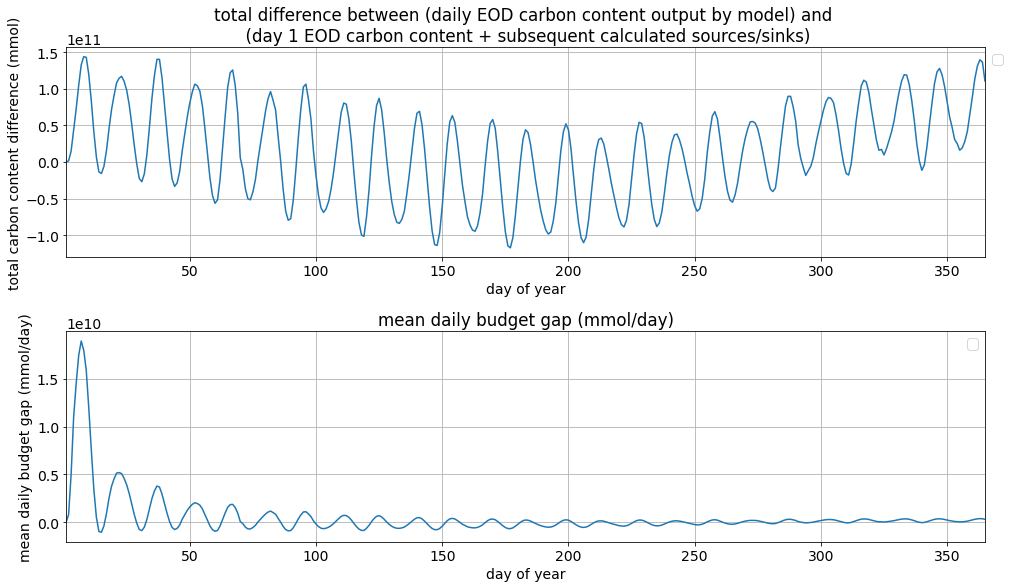

In [33]:
SNAPest = w['DIC_SNAP_mmol_tot_ar'][:]
SMSest = day1_SNAP_plus_cum_diff

fact = 0.7
fig, axs = plt.subplots(2,1, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

SNAPest = w['DIC_SNAP_mmol_tot_ar'][:]
SMSest = day1_SNAP_plus_cum_diff

axs[0].plot(np.arange(1,dayslen+1,1), (SNAPest - SMSest))

mean_budgdiff = np.zeros_like(SNAPest)
for i in range(0,dayslen):
    mean_budgdiff[i] = (SNAPest[i]-SMSest[i])/(i+1)

axs[0].set_title('total difference between (daily EOD carbon content output by model) and \n (day 1 EOD carbon content + subsequent calculated sources/sinks)')
axs[0].set_ylabel('total carbon content difference (mmol)')
axs[1].set_title('mean daily budget gap (mmol/day)')
axs[1].set_ylabel('mean daily budget gap (mmol/day)')


axs[1].plot(np.arange(1,dayslen+1,1), (mean_budgdiff))

for i in range(0,2):
    axs[i].grid();
    axs[i].set_xlabel('day of year')
    axs[i].set_xlim([1,dayslen])
    axs[i].legend(bbox_to_anchor = [1 ,1])
plt.tight_layout()


In [34]:
print('mmol/day budget gap:')
print('([total budget gap]/no. of days)')
budgetgap = int((SNAPest[dayslen-1] - SMSest[dayslen-1])/dayslen)
print(f"{Decimal(budgetgap):.8E}")
#print(f"{Decimal(int(SNAPest[dayslen-1] - SMSest[dayslen-1]):.8E}") 


mmol/day budget gap:
([total budget gap]/no. of days)
3.03001117E+8


In [35]:

#total lateral diffusion (mmol/day) = 
#coeff_ld * ∇ DIC * cross-sectional area * seconds/day

print('total lateral diffusion (mmol/day) = ')
print('coeff_ld (m2/s) * ∇ DIC (mmol/m3/m) * cross-sectional area (m2) * seconds/day')
print('')
#mmk = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
#print(mmk)
e2t_here = (mmk['e2t'][0,:,20])
e3t_here = (mmk['e3t_0'][0,:,:,20])
tmask_here = mmk['tmask'][0,:,:,20]
e2t_here_broad = np.zeros_like(e3t_here)
for i in range(0,40):
    e2t_here_broad[i,:] = e2t_here

jdf_crossection = (e2t_here_broad*tmask_here*e3t_here)

tot_jdf_cross = (np.nansum(jdf_crossection))


coeff_ld = 1.5

grad_DIC = 10
TLD = coeff_ld * grad_DIC * tot_jdf_cross * sid

print(f'Assuming a DIC gradient of {grad_DIC} umol/m across the JDF boundary,')
print('our BOE tot. lat diff would be')
(print(f"{Decimal(TLD):.8E} mmol/day"))
print()

grad_DIC = 1
TLD = coeff_ld * grad_DIC * tot_jdf_cross * sid

print(f'Assuming a DIC gradient of {grad_DIC} umol/m across the JDF boundary,')
print('our BOE tot. lat diff would be')
(print(f"{Decimal(TLD):.8E} mmol/day"))
print()

grad_DIC = 0.05
TLD = coeff_ld * grad_DIC * tot_jdf_cross * sid

print(f'Assuming a DIC gradient of {grad_DIC} umol/m across the JDF boundary,')
print('our BOE tot. lat diff would be')
(print(f"{Decimal(TLD):.8E} mmol/day"))

print(f'({grad_DIC} umol/m = {grad_DIC*1000} umol/km)')
print()
print('our daily budget gap is ')
(print(f"{Decimal(budgetgap):.8E} mmol/day"))

#total lateral diffusion (mmol/day) = 
#coeff_ld * ∇ DIC * cross-sectional area * seconds/day

total lateral diffusion (mmol/day) = 
coeff_ld (m2/s) * ∇ DIC (mmol/m3/m) * cross-sectional area (m2) * seconds/day

Assuming a DIC gradient of 10 umol/m across the JDF boundary,
our BOE tot. lat diff would be
6.08274530E+12 mmol/day

Assuming a DIC gradient of 1 umol/m across the JDF boundary,
our BOE tot. lat diff would be
6.08274530E+11 mmol/day

Assuming a DIC gradient of 0.05 umol/m across the JDF boundary,
our BOE tot. lat diff would be
3.04137265E+10 mmol/day
(0.05 umol/m = 50.0 umol/km)

our daily budget gap is 
3.03001117E+8 mmol/day


## what is the residence time of our system? 


In [36]:
tot_in_dom = w['DIC_SNAP_mmol_tot_ar'][:]

print('total mmol in system - mean (mmol)')
print(np.nanmean(tot_in_dom))

print('total transport into system - mean (mmol/day)')
tot_pos = w['DIC_UT_mmol_day_pos_ar'][:]+w['DIC_VT_mmol_day_pos_ar'][:]
print(np.nanmean(tot_pos))

print('total transport out of system - mean (mmol/day)')
tot_neg = w['DIC_UT_mmol_day_neg_ar'][:]+w['DIC_VT_mmol_day_neg_ar'][:]
print(np.nanmean(tot_neg))

print('simple res time based on pos. transp.')
print(np.nanmean(tot_in_dom)/np.nanmean(tot_pos))

print('simple res time based on neg. transp.')
print(np.nanmean(tot_in_dom)/np.nanmean(tot_neg))

total mmol in system - mean (mmol)
4799828000000000.0
total transport into system - mean (mmol/day)
38755510000000.0
total transport out of system - mean (mmol/day)
-38593310000000.0
simple res time based on pos. transp.
123.84891
simple res time based on neg. transp.
-124.36943


In [37]:
print(w)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): days(365)
    variables(dimensions): float32 vol_km3_tot_ar(days), float32 DIC_mmol_tot_ar(days), float32 DIC_SNAP_mmol_tot_ar(days), float32 riv_DIC_mmol_day_tot_ar(days), float32 PRD_DIC_mmol_day_tot_ar(days), float32 UNC_DIC_mmol_day_tot_ar(days), float32 REM_DIC_mmol_day_tot_ar(days), float32 DIC_UT_mmol_day_tot_ar(days), float32 DIC_VT_mmol_day_tot_ar(days), float32 ASflux_mmol_day_tot_ar(days), float32 daychange_mmol_day_tot_ar(days), float32 DIC_VT_mmol_day_pos_ar(days), float32 DIC_VT_mmol_day_neg_ar(days), float32 DIC_UT_mmol_day_pos_ar(days), float32 DIC_UT_mmol_day_neg_ar(days), float32 DIC_ATX_mmol_day_pos_ar(days), float32 DIC_ATX_mmol_day_neg_ar(days), float32 DIC_ATY_mmol_day_pos_ar(days), float32 DIC_ATY_mmol_day_neg_ar(days), float32 DIC_DTX_mmol_day_pos_ar(days), float32 DIC_DTX_mmol_day_neg_ar(days), float32 DIC_DTY_mmol_day_pos_ar(days), float32 DIC_DTY_mmol_